# Transfer Learning with TensorFlow - Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: Fine-tuning

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

In [1]:
!python -m wget -O https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


Saved under helper_functions (1).py


In [1]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
%matplotlib inline

> 🔑 **Note:** If you're running this notebook in Google Colab, when time out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want to access your helper functions

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

In [3]:
# Get 10% of training data of 10 classes of Food 101
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')


Saved under 10_food_classes_10_percent.zip


In [2]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [3]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [4]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory = train_dir, 
                                                                   image_size = IMG_SIZE,
                                                                   label_mode = 'categorical',
                                                                   batch_size = BATCH_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                       image_size = IMG_SIZE,
                                                       label_mode = 'categorical',
                                                       batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [6]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.85867348e+01 1.95867348e+01 1.15867348e+01]
   [2.02857151e+01 2.12857151e+01 1.32857141e+01]
   [2.20765305e+01 2.30765305e+01 1.50765305e+01]
   ...
   [5.71631050e+01 4.85916328e+01 3.93773689e+01]
   [5.68469772e+01 4.65867233e+01 3.66581650e+01]
   [6.36021919e+01 4.89133492e+01 3.81429634e+01]]

  [[1.99285717e+01 2.09285717e+01 1.29285717e+01]
   [1.99285717e+01 2.09285717e+01 1.29285717e+01]
   [2.07857151e+01 2.17857151e+01 1.37857141e+01]
   ...
   [7.09337311e+01 6.23622589e+01 5.31479950e+01]
   [5.95816078e+01 4.97244644e+01 3.96530380e+01]
   [6.29898491e+01 5.12755661e+01 3.93469925e+01]]

  [[1.82142868e+01 1.92142868e+01 1.12142859e+01]
   [1.82142868e+01 1.92142868e+01 1.12142859e+01]
   [1.72142868e+01 1.82142868e+01 1.02142859e+01]
   ...
   [5.28775864e+01 4.59898567e+01 3.47551498e+01]
   [7.24488907e+01 6.60203171e+01 5.42346039e+01]
   [5.77091408e+01 5.12805710e+01 3.94948540e+01]]

  ...

  [[1.01428566e+02 1.02428566e+02 9.64285660e+01]
   [1

## Model 0:  Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our model

In [8]:
# 1. Create base model with tf.keras.Applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape =(224,224,3), name='input_layer')

# 4. If using model like ResNet50V2 you will need to normalize inputs (you dont' have to for effnet)
#x = tf.keras.layers.Rescaling(1/255.)(inputs)

# 5. Pass the inputs 
x = base_model(inputs)
print(f'Shape after passing through base model {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D:{x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation ='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. compile the model
model_0.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                       epochs = 5,
                       steps_per_epoch = len(train_data_10_percent),
                       validation_data = test_data,
                       validation_steps = int(0.25 * len(test_data)),
                       callbacks = [create_tensorboard_callback(dir_name ='transfer_learning',
                                                                experiment_name='10_percent_feature_extraction')])

Shape after passing through base model (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210915-202014


D:\Anaconda3\envs\TensorflowTut\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
24/24 [==============================] - 19s 411ms/step - loss: 2.0061 - accuracy: 0.3533 - val_loss: 1.4179 - val_accuracy: 0.6842
Epoch 2/5
24/24 [==============================] - 7s 306ms/step - loss: 1.2025 - accuracy: 0.7440 - val_loss: 0.9393 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - 7s 309ms/step - loss: 0.8608 - accuracy: 0.8000 - val_loss: 0.7903 - val_accuracy: 0.7993
Epoch 4/5
24/24 [==============================] - 7s 297ms/step - loss: 0.6983 - accuracy: 0.8160 - val_loss: 0.6860 - val_accuracy: 0.8076
Epoch 5/5
24/24 [==============================] - 7s 299ms/step - loss: 0.6003 - accuracy: 0.8573 - val_loss: 0.6272 - val_accuracy: 0.8289


In [9]:
# Evaluate on the full test datset
model_0.evaluate(test_data)

79/79 [==============================] - 13s 161ms/step - loss: 0.6220 - accuracy: 0.8392


[0.621957540512085, 0.8392000198364258]

In [10]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [11]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [12]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


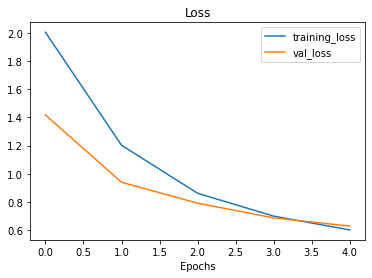

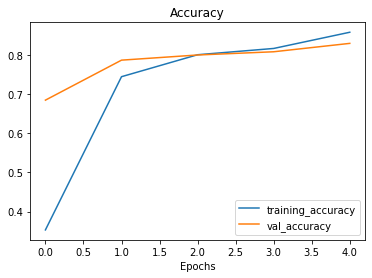

In [13]:
# Check out our model's loss curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)..

But then it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [14]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor: \n {input_tensor} \n')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D Global average pooled random tensor: \n {global_average_pooled_tensor} \n')

# check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D Global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [15]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [16]:
print(f'Random input tensor: \n {input_tensor} \n')

# Pass the random tensor through a global max pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f'2D Global average pooled random tensor: \n {global_average_pooled_tensor} \n')

# check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D Global average pooled random tensor: 
 [[0.9058464 1.1603122 1.6994323]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is, is because what often happens is pretrained models outputs a **feature vector** (a long tensor of numbers which represents the learned representation of a model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can be used to extract patterns out of our own specific problem

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of training data, but how does it go with 1% of the training data ... how about we set up a bunch of experimetns to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation. 

> 🔑 **Note**: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consitency across evaluation metrics. 

### Getting and preprocessing data for model_1

In [17]:
# Download and unzip data 
!python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip


Saved under 10_food_classes_1_percent (1).zip


In [18]:
unzip_data('10_food_classes_1_percent.zip')

In [19]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [20]:
# How many images are we working with?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [21]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(train_dir_1_percent,
                                                                  label_mode = 'categorical',
                                                                  image_size=IMG_SIZE,
                                                                  batch_size=BATCH_SIZE) # default = 32

test_data_1_percent = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 label_mode = 'categorical',
                                                                 image_size= IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow data augmentation documentation.

Off the top of our heads, after reading the documentation, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zoom, etc.
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    #layers.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet is built-in
], name = 'data_augmentation')

### Visualize our data augmentation layer (and see what happens to our data)

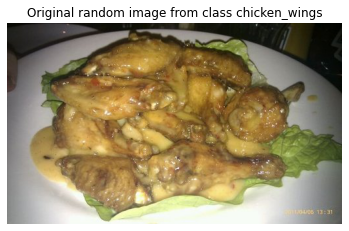

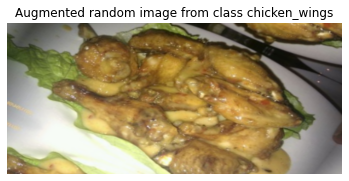

In [23]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class {target_class}')
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'Augmented random image from class {target_class}')
plt.axis(False);

## Model 1 : Feature extraction transfer learning on 1% of the data with data augmentation

In [24]:
# setup the input shape and base model, freezing the base model of layers
input_shape = IMG_SIZE + (3, )
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = 'input_layer')

# add in data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name ='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = 'softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_1_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25 * len(test_data)),
                               # Track model training logs
                               callbacks = [create_tensorboard_callback(dir_name ='transfer_learning',
                                                                        experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210915-202147
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.4495 - accuracy: 0.1286 - val_loss: 2.2245 - val_accuracy: 0.1727
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1436 - accuracy: 0.2857 - val_loss: 2.1139 - val_accuracy: 0.2303
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9927 - accuracy: 0.4000 - val_loss: 1.9959 - val_accuracy: 0.3141
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8152 - accuracy: 0.5571 - val_loss: 1.9012 - val_accuracy: 0.3799
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6762 - accuracy: 0.5571 - val_loss: 1.8254 - val_accuracy: 0.4260


In [25]:
# Check out a model summary 
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [26]:
# Evaluate on the full test set
results_1_percent_data_aug = model_1.evaluate(test_data_1_percent)
results_1_percent_data_aug

79/79 [==============================] - 12s 148ms/step - loss: 1.8253 - accuracy: 0.4364


[1.8252841234207153, 0.43639999628067017]

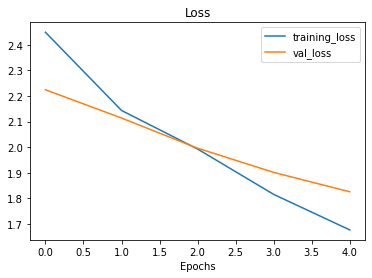

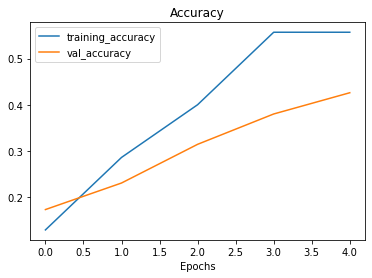

In [27]:
# How do the model with 1% and data aug loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning on 10% of the data with data augmentation

In [28]:
# Getting the data
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(train_dir_10_percent,
                                                                  label_mode = 'categorical',
                                                                  image_size=IMG_SIZE,
                                                                  batch_size=BATCH_SIZE) # default = 32

test_data_10_percent = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 label_mode = 'categorical',
                                                                 image_size= IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
# Create model 2 with data augmentation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    #layers.Rescaling(1/255.) # In this model not required
    
], name = 'data_augmentation')

# Setup the input shape to our model
input_shape = IMG_SIZE + (3, ) # (224, 224, 3)

In [55]:
# Create a frozen base model (also called backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = 'input_layer')

# Data augmentation layer
x = data_augmentation(inputs)
# EffNet Layer
x = base_model(x)
# Pool output features of the base model
x = layers.GlobalAvgPool2D(name = 'global_avg_pooling')(x)
# Put a dense layer on as the output 
outputs = layers.Dense(10, activation = 'softmax', name='output_layer')(x)

# Make model
model_2 = keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

### Creating a ModelCheckpointCallback

The model checkpoint callback intermediately saves our model (the full model or just the weights during training). This is usfeul so we can come and start where we left off.

In [56]:
# Checkpoint path
checkpoint_path = './tmp/ten_percent_model_checkpoints_weights/'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq = 'epoch',
                                                        verbose = 1)

### Fit model 2 passing in the ModelCheckpoint callback

In [57]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                         batch_size=32,
                                         epochs = initial_epochs,
                                         validation_data = test_data,
                                         validation_steps = int(0.25 * len(test_data)),
                                         callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                 experiment_name='10_percent_data_aug'),
                                                     checkpoint_callback])  

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210915-212259
Epoch 1/5


D:\Anaconda3\envs\TensorflowTut\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


24/24 [==============================] - 17s 530ms/step - loss: 2.0631 - accuracy: 0.2747 - val_loss: 1.5026 - val_accuracy: 0.5921

Epoch 00001: saving model to ./tmp/ten_percent_model_checkpoints_weights\
Epoch 2/5
24/24 [==============================] - 12s 484ms/step - loss: 1.4321 - accuracy: 0.6253 - val_loss: 1.0786 - val_accuracy: 0.7220

Epoch 00002: saving model to ./tmp/ten_percent_model_checkpoints_weights\
Epoch 3/5
24/24 [==============================] - 11s 466ms/step - loss: 1.1337 - accuracy: 0.7040 - val_loss: 0.8957 - val_accuracy: 0.7664

Epoch 00003: saving model to ./tmp/ten_percent_model_checkpoints_weights\
Epoch 4/5
24/24 [==============================] - 12s 517ms/step - loss: 0.9581 - accuracy: 0.7547 - val_loss: 0.7664 - val_accuracy: 0.7944

Epoch 00004: saving model to ./tmp/ten_percent_model_checkpoints_weights\
Epoch 5/5
24/24 [==============================] - 12s 509ms/step - loss: 0.8414 - accuracy: 0.7707 - val_loss: 0.7147 - val_accuracy: 0.7911


In [58]:
model_0.evaluate(test_data)

79/79 [==============================] - 13s 160ms/step - loss: 0.6220 - accuracy: 0.8392


[0.6219576597213745, 0.8392000198364258]

In [59]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 13s 155ms/step - loss: 0.7095 - accuracy: 0.8120


[0.7095127105712891, 0.8119999766349792]

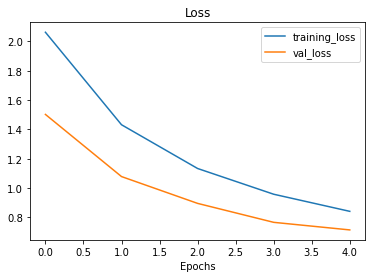

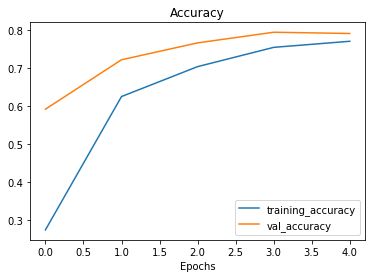

In [60]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [61]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [63]:
# Evaluate model_2 with laoded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 13s 154ms/step - loss: 0.7095 - accuracy: 0.8120


In [64]:
# If the results from our previously evaluated model_2 match the loaded weights
results_10_percent_data_aug == loaded_weights_model_results

False

In [65]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [67]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## Model 3: Fine-tunning an existing model with 10% of data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [68]:
model_2.layers

In [70]:
# are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable, layer.name)

<keras.engine.input_layer.InputLayer object at 0x00000210559270A0> True input_layer
<keras.engine.sequential.Sequential object at 0x0000021053244130> True data_augmentation
<keras.engine.functional.Functional object at 0x00000210569541C0> False efficientnetb0
<keras.layers.pooling.GlobalAveragePooling2D object at 0x0000021058A3C280> True global_avg_pooling
<keras.layers.core.Dense object at 0x0000021055F2B3D0> True output_layer


In [74]:
#what layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [75]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [81]:
1e-4

0.0001

In [82]:
# To begin fine-tuning, let's start by setting the last 10 layers of our bsae_model.trianable = True
base_model.trainable = True

# Freeze all layers except for last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), # when fine-tuning you typically want to lower the learning rate by 10X
               metrics = ['accuracy'])

>  🔑**Note:** When you using fine tunning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10X (though different sources will claim other values)
A good resource for information on this is the ULMFit paper https://arxiv.org/abs/1801.06146 

In [83]:
# Check which layers are tunable(trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [85]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [86]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5 

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              epochs = fine_tune_epochs, 
                                              validation_data = test_data,
                                              validation_steps = int(0.25 * len(test_data)),
                                              initial_epoch=history_10_percent_data_aug.epoch[-1],
                                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                    experiment_name='10_percent_fine_tune_last_10')]) #start training from previous last epoch

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210915-220331
Epoch 5/10


D:\Anaconda3\envs\TensorflowTut\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


24/24 [==============================] - 21s 600ms/step - loss: 0.8932 - accuracy: 0.7587 - val_loss: 0.6402 - val_accuracy: 0.8141
Epoch 6/10
24/24 [==============================] - 12s 482ms/step - loss: 0.7493 - accuracy: 0.8000 - val_loss: 0.5824 - val_accuracy: 0.8306
Epoch 7/10
24/24 [==============================] - 11s 470ms/step - loss: 0.6917 - accuracy: 0.8320 - val_loss: 0.5720 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 12s 523ms/step - loss: 0.6269 - accuracy: 0.8400 - val_loss: 0.5681 - val_accuracy: 0.8306
Epoch 9/10
24/24 [==============================] - 12s 490ms/step - loss: 0.5858 - accuracy: 0.8387 - val_loss: 0.5196 - val_accuracy: 0.8388
Epoch 10/10
24/24 [==============================] - 11s 468ms/step - loss: 0.5616 - accuracy: 0.8520 - val_loss: 0.5226 - val_accuracy: 0.8306


In [87]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 13s 159ms/step - loss: 0.5082 - accuracy: 0.8400


In [88]:
results_10_percent_data_aug

[0.7095127105712891, 0.8119999766349792]

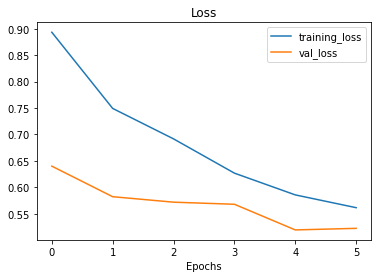

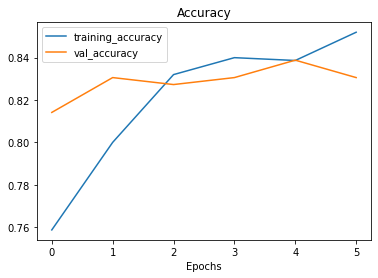

In [89]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` functions works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [101]:
# let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs = 5):
    '''
    Compares two tensorflow history objects.
    '''
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']
    
    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']
    
    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']
    
    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']
    
    #Make plot for accuracy
    plt.figure(figsize = (8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label = 'Training Accuracy')
    plt.plot(total_val_acc, label = 'Val Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = 'Start fine tuning')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation accuracy')
    
    #Make plot for loss
    plt.figure(figsize = (8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label = 'Training Loss')
    plt.plot(total_val_loss, label = 'Val Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = 'Start fine tuning')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    
    

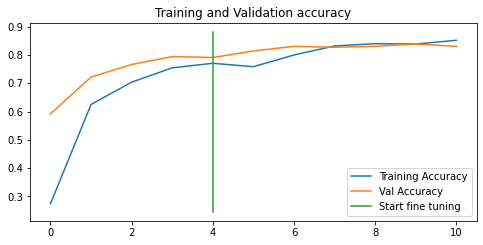

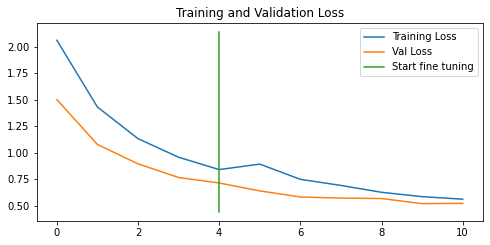

In [102]:
compare_histories(history_10_percent_data_aug, 
                  history_fine_10_percent_data_aug,
                  initial_epochs = initial_epochs)